In [82]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCMT, GroverOperator
from math import pi
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit import Parameter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_image_path
import seaborn as sns


In [2]:
def get_diffuser(total_qubits):
    mct = MCMT('x', total_qubits-1, 1)
    qc = QuantumCircuit(total_qubits)
    qc.h(range(total_qubits))
    qc.x(range(total_qubits))

    qc.h(-1)
    qc.compose(mct, range(total_qubits), inplace=True)
    qc.h(-1)
    
    qc.x(range(total_qubits))
    qc.h(range(total_qubits))
    return qc

In [3]:
def classical_grover(oracle):
    total_qubits = oracle.num_qubits
    qc = QuantumCircuit(total_qubits)
    grover = GroverOperator(oracle).decompose()
    qc.h(range(total_qubits))
    qc.compose(grover, range(total_qubits), inplace=True)
    return qc

In [4]:
def phase_oracle(states):
    total_qubits = len(states[0])
    mct = MCMT('z', total_qubits-1, 1)
    
    qc = QuantumCircuit(total_qubits, name="oracle")
    for state in states:
        zeros = [i for i, bit in enumerate(state[::-1]) if bit == '0']
        if(zeros): qc.x(zeros)
        qc.compose(mct,range(total_qubits),inplace=True)
        if(zeros): qc.x(zeros)
    return qc

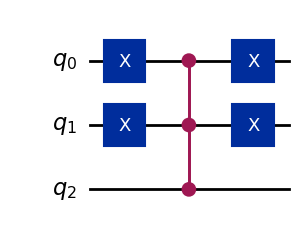

In [5]:
oracle = phase_oracle(['100'])
oracle.draw('mpl')

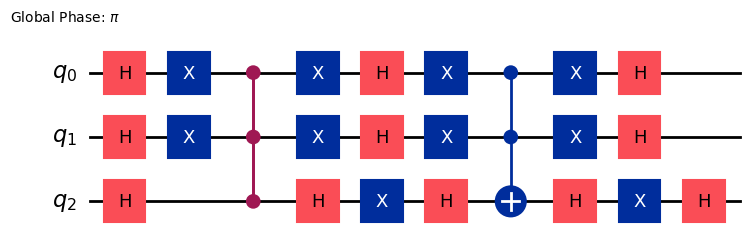

In [6]:
classical_grover(oracle).draw('mpl')

In [7]:
def get_counts(qc, sim=AerSimulator(), shots=1000):
    qc_c = qc.copy()
    qc_c.measure_all()
    transpiled = transpile(qc_c, sim)
    return sim.run(transpiled, shots=shots).result().get_counts()

In [8]:
def new_grover(oracle):
    theta = Parameter('theta')
    total_qubits = oracle.num_qubits
    
    qc = QuantumCircuit(total_qubits)
    qc.ry(theta, range(total_qubits))
    qc.barrier()
    qc.append(oracle, range(total_qubits))
    qc.barrier()
    qc.compose(get_diffuser(total_qubits), range(total_qubits), inplace=True)
    
    return qc, theta

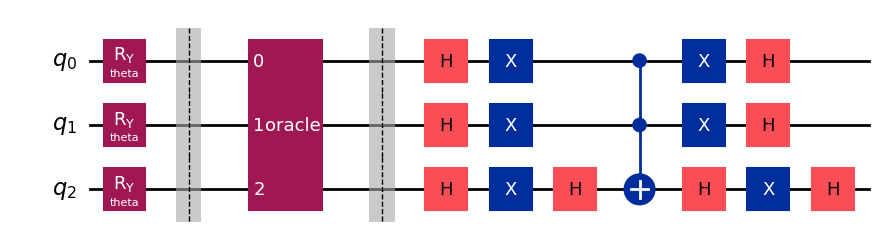

In [9]:
n_grover,theta = new_grover(oracle) 
n_grover.draw('mpl')

In [10]:
def find_best_angle(theta, qc, values_space, target_bit_string, debug=False):
    best_angle = 0
    best_total = 0
    
    for angle in values_space:
        bc = qc.assign_parameters({theta:angle})
        counts = get_counts(bc)

        value = 0
        if(counts.get(target_bit_string)):
            value = counts[target_bit_string]

        if(value > best_total):
            best_total = value
            best_angle = angle
        
        if(debug):
            print(angle, value)

    return best_angle, best_total

In [11]:
best_angle, best_total = find_best_angle(theta, n_grover, np.linspace(0, pi, num=1000), '001', debug=True)

0.0 61
0.0031447373909807737 46
0.006289474781961547 54
0.009434212172942321 59
0.012578949563923095 59
0.01572368695490387 60
0.018868424345884642 55
0.022013161736865416 56
0.02515789912784619 47
0.028302636518826963 55
0.03144737390980774 52
0.034592111300788514 54
0.037736848691769284 46
0.040881586082750054 54
0.04402632347373083 55
0.04717106086471161 59
0.05031579825569238 71
0.05346053564667315 44
0.056605273037653926 42
0.0597500104286347 49
0.06289474781961547 46
0.06603948521059624 55
0.06918422260157703 57
0.0723289599925578 59
0.07547369738353857 53
0.07861843477451934 57
0.08176317216550011 48
0.08490790955648089 50
0.08805264694746166 49
0.09119738433844243 54
0.09434212172942322 52
0.09748685912040399 50
0.10063159651138476 39
0.10377633390236553 34
0.1069210712933463 47
0.11006580868432708 49
0.11321054607530785 40
0.11635528346628862 54
0.1195000208572694 52
0.12264475824825018 42
0.12578949563923095 35
0.12893423303021173 40
0.1320789704211925 43
0.13522370781217327 

In [12]:
best_angle, best_total

(2.506355700611677, 159)

In [13]:
BIT_STRINGS_3 = ['000', '001', '010', '011', '100', '101', '110', '111']

In [14]:
def compare_old_new_1_bit_string(bit_strings, values_space, debug=False):
    old = {}
    new = {}
    angles = {}
    
    for bit_string in bit_strings:
        oracle = phase_oracle([bit_string])

        old_ = classical_grover(oracle.copy())
        if(debug):
            display(old_.draw('mpl'))
        
        old_counts = get_counts(old_)
        old_total = 0
        if(old_counts.get(bit_string)):
            old[bit_string] = old_counts[bit_string]

        new_, theta = new_grover(oracle.copy())
        angle, max_ = find_best_angle(theta, new_, values_space, bit_string)
        new[bit_string] = max_
        angles[bit_string] = angle

    data = {"old":old, "new":new, "angles":angles}
    return pd.DataFrame(data, columns=("old", "new", "angles"), index=bit_strings)
        
        
        

In [15]:
results_1 = compare_old_new_1_bit_string(BIT_STRINGS_3, np.linspace(0, pi, num=500))
results_1

,old,new,angles
000,787,949,1.013620
001,784,808,1.385071
010,780,819,1.479508
011,791,818,1.680972
100,768,811,1.397662
101,766,812,1.712451
110,765,819,1.699860
111,789,942,2.058719


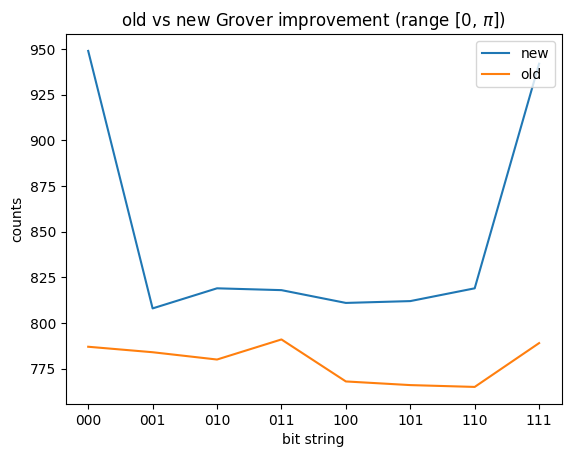

In [16]:
plt.plot(results_1.index.tolist(), results_1['new'], label="new")
plt.plot(results_1.index.tolist(), results_1['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")

plt.savefig(get_image_path("superposition-improvement-grover-algorithm-range-0-to-pi.png"))
plt.show()

In [17]:
results_2 = compare_old_new_1_bit_string(BIT_STRINGS_3, np.linspace(0, 2*pi, num=500))
results_2

,old,new,angles
000,774,939,1.082874
001,783,809,1.435437
010,779,817,1.473212
011,778,810,1.699860
100,759,826,1.422846
101,796,820,1.624310
110,787,806,1.674677
111,778,937,2.077606


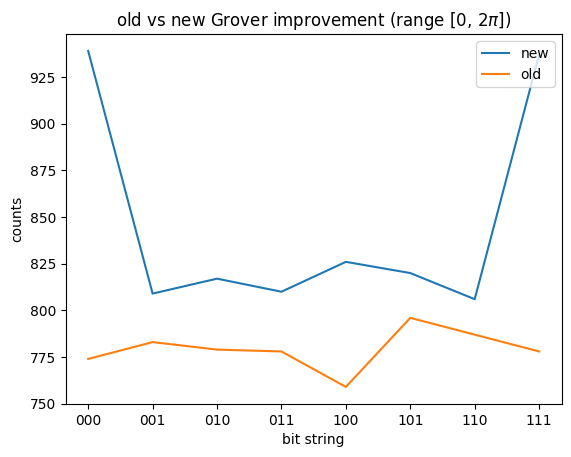

In [18]:
plt.plot(results_2.index.tolist(), results_2['new'], label="new")
plt.plot(results_2.index.tolist(), results_2['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $2\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")

plt.savefig(get_image_path("superposition-improvement-grover-algorithm-range-0-to-2pi.png"))
plt.show()

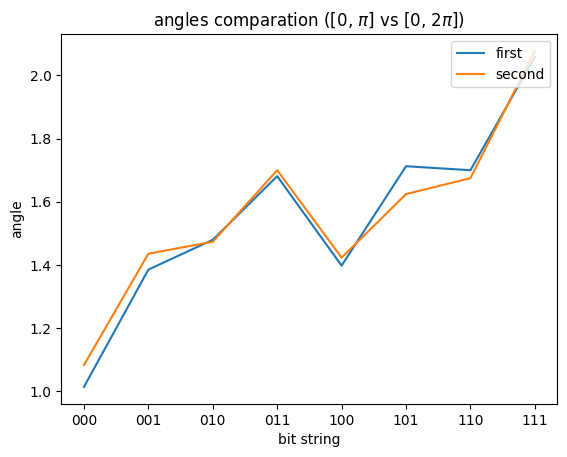

In [19]:
plt.plot(BIT_STRINGS_3, results_1['angles'], label="first")
plt.plot(BIT_STRINGS_3, results_2['angles'], label="second")
plt.title('angles comparation ([0, $\pi$] vs [0, $2\pi$])')
plt.xlabel("bit string")
plt.ylabel("angle")
plt.legend(loc="upper right")
plt.savefig(get_image_path("improvement-grover-algorithm-angles-comparation-0-pi-and-2pi.png"))
plt.show()

In [21]:
results_3 = compare_old_new_1_bit_string([bin(i)[2:].zfill(4) for i in range(2**4)], np.linspace(0, 2*pi, num=500))
results_3

,old,new,angles
0000,443,887,0.352564
0001,476,547,1.183606
0010,466,533,1.208789
0011,467,495,1.561353
0100,460,552,1.372479
0101,449,510,1.636902
0110,470,492,1.573944
0111,475,539,1.800592
1000,473,525,1.422846
1001,472,497,1.448029


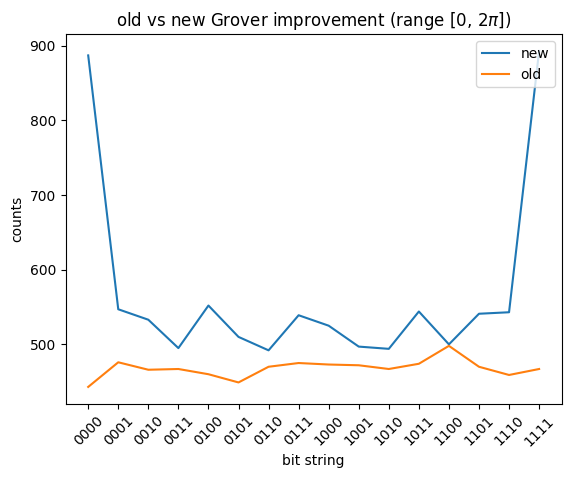

In [34]:
plt.plot(results_3.index.tolist(), results_3['new'], label="new")
plt.plot(results_3.index.tolist(), results_3['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $2\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.xticks(rotation = 45)
plt.legend(loc="upper right")
plt.savefig(get_image_path("improvement-grover-algorithm-4bits-0-to-2pi.png"))
plt.show()

In [25]:
pi/2

1.5707963267948966

In [30]:
mid_values = results_3["angles"].drop(["0000", "1111"])
mid_values

0001    1.183606
0010    1.208789
0011    1.561353
0100    1.372479
0101    1.636902
0110    1.573944
0111    1.800592
1000    1.422846
1001    1.448029
1010    1.712451
1011    1.964282
1100    1.523578
1101    1.775409
1110    1.813184
Name: angles, dtype: float64

In [56]:
mid_values.describe()

count    14.000000
mean      1.571246
std       0.230764
min       1.183606
25%       1.429141
50%       1.567648
75%       1.759670
max       1.964282
Name: angles, dtype: float64

In [73]:
mid_values.mean(), pi/2

(1.5712460251421039, 1.5707963267948966)

In [66]:
new_angle = 1.372479

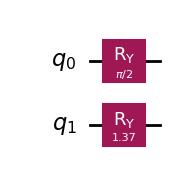

In [67]:
test = QuantumCircuit(2)
test.ry(pi/2, 0)
test.ry(new_angle, 1)
test.draw('mpl')

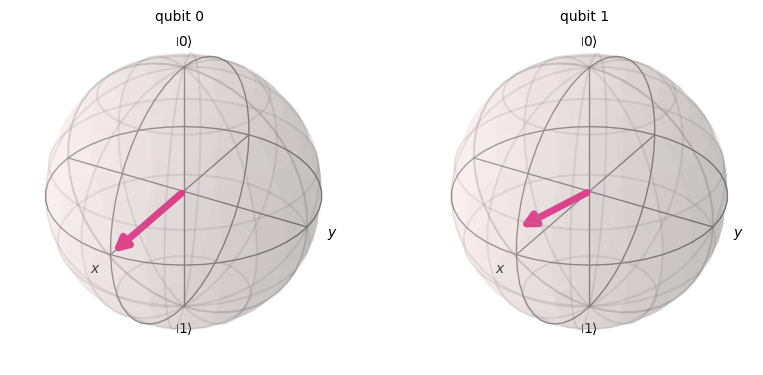

In [68]:
plot_bloch_multivector(test)

---

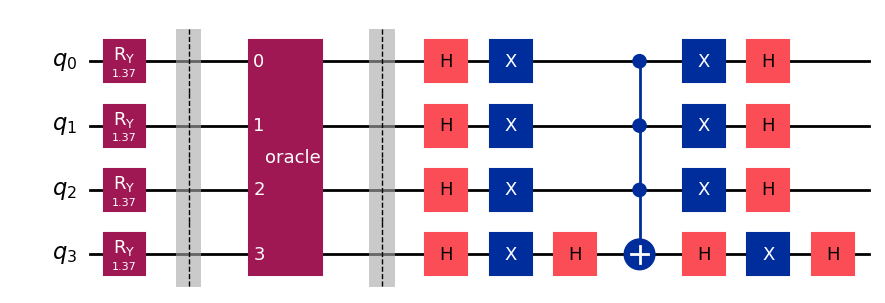

In [69]:
oracle = phase_oracle(['1010'])
new_, theta = new_grover(oracle.copy())
new_t = new_.assign_parameters({theta:new_angle})
new_t.draw('mpl')

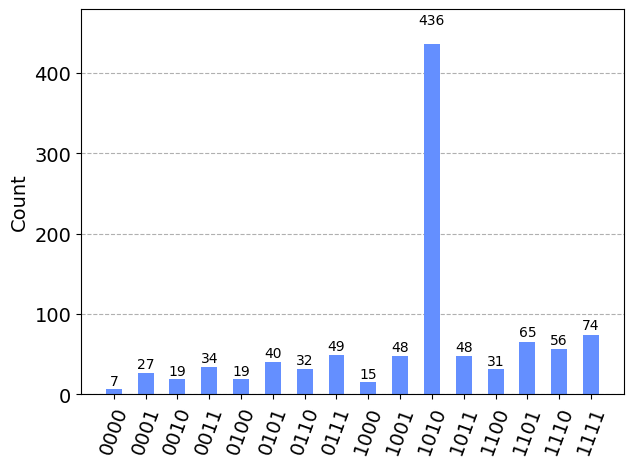

In [70]:
plot_histogram(get_counts(new_t))

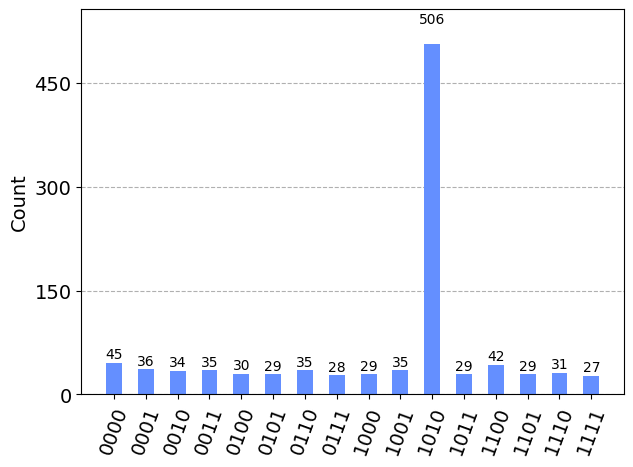

In [71]:
g = classical_grover(oracle.copy())
plot_histogram(get_counts(g))

---

In [90]:
data = results_3
data["index"] = list(range(16))
data

,old,new,angles,index
0000,443,887,0.352564,0
0001,476,547,1.183606,1
0010,466,533,1.208789,2
0011,467,495,1.561353,3
0100,460,552,1.372479,4
0101,449,510,1.636902,5
0110,470,492,1.573944,6
0111,475,539,1.800592,7
1000,473,525,1.422846,8
1001,472,497,1.448029,9


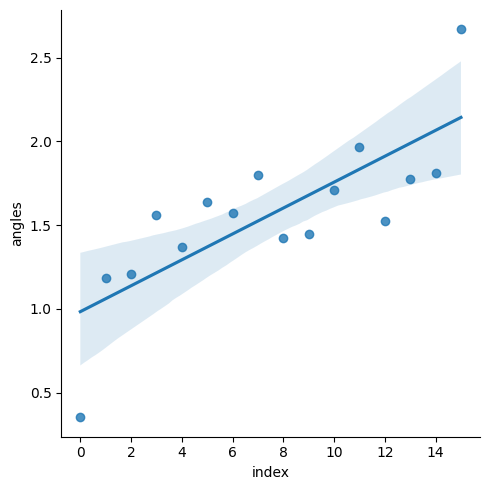

In [91]:
sns.lmplot(x="index", y='angles', data=data)